In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
import networkx as nx
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

**Note this notebook only expects to be run from a Python 3 kernel (due to networkx)**

In [2]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.3008761405944824s.
Done.


In [3]:
# linear model fits
regr_fits = pd.read_csv('./data_sharing/regr_fits_final.csv', index_col=0)

Only look at buffering interactions (lower norm in linear interaction model fit)

In [4]:
doubles = regr_fits.query('ts_norm2 < 0.9').index
singles = np.union1d(regr_fits.index.map(lambda x: x.split('_')[0]), regr_fits.index.map(lambda x: x.split('_')[1]))

in_mean_pop = mean_pop.cells.query('num_targets==1').index.map(lambda x: x.split('_')[0])
singles = np.intersect1d(singles, in_mean_pop)

doubles = [double for double in doubles if double.split('_')[0] in singles and double.split('_')[1] in singles]

Create graphs

In [5]:
G = nx.MultiDiGraph()
buf_G = nx.DiGraph()

Add all the single genes

In [6]:
for single in singles:
    G.add_node(single, name=single)
    buf_G.add_node(single, name=single)

Add edges according to the model fits, with a "repressing arrow" pointing from gene A to gene B if the gene A phenotype better explains the double.

In [7]:
for double in doubles:
    first, second = double.split('_')
    emap = regr_fits.loc[double, 'emap']
    strength = regr_fits.loc[double, 'abs_log_ts_ratio']
    if np.isnan(emap):
        emap = 0
    if first in singles and second in singles:
        strength_first = regr_fits.loc[double, 'ts_coef_first']
        strength_second = regr_fits.loc[double, 'ts_coef_second']
        # only add strong interactions
        if emap > 3 and strength > np.log10(1.25):
            if strength_first > strength_second:
                G.add_edge(first, second, weight=1.41 - regr_fits.loc[double, 'ts_norm2'], emap=emap)
                buf_G.add_edge(first, second, weight=1.41 - regr_fits.loc[double, 'ts_norm2'], emap=emap)
            else:
                G.add_edge(second, first, weight=1.41 - regr_fits.loc[double, 'ts_norm2'], emap=emap)
                buf_G.add_edge(second, first, weight=1.41 - regr_fits.loc[double, 'ts_norm2'], emap=emap)
        else:
            G.add_edge(first, second, weight=5*regr_fits.loc[double, 'ts_norm2'], emap=-emap)
            G.add_edge(second, first, weight=5*regr_fits.loc[double, 'ts_norm2'], emap=-emap)

Remove all genes that didn't participate in interactions

In [8]:
buf_G.remove_nodes_from(list(nx.isolates(buf_G)))
buf_G.remove_nodes_from(['TGFBR2'])

# genes that ended up in graph
interactions = [double for double in doubles if double.split('_')[0] in buf_G.nodes() and double.split('_')[1] in buf_G.nodes()]
interaction_singles = np.union1d(list(map(lambda x: x.split('_')[0], interactions)),
                                 list(map(lambda x: x.split('_')[1], interactions)))

Cluster genes according to gene expression.

In [9]:
from scipy.cluster.hierarchy import fclusterdata

expr = mean_pop.where(genes='mean > 0.25',
                      normalized=True,
                      gene_names=True
                     )
expr = expr/expr.std()
expr = expr.loc[[n + '_NegCtrl0' for n in singles]]

clusters = pd.Series(fclusterdata(expr.loc[pd.Series(interaction_singles) + '_NegCtrl0'],
                                  0.8, method='average', metric='correlation'),
                     interaction_singles)
clusters.sort_values()

MAP2K3     1
MAP2K6     1
KLF1       1
ZC3HAV1    1
IGDCC3     2
PTPN12     2
SET        2
UBASH3B    2
ETS2       3
MAPK1      3
FOSB       4
CEBPE      4
CEBPB      4
SPI1       4
CEBPA      4
IKZF3      5
ZBTB10     5
DUSP9      5
OSR2       6
RUNX1T1    7
dtype: int32

Visualize graph

In [10]:
from matplotlib.colors import to_hex

In [11]:
cluster_colors = list(map(to_hex, sns.color_palette('muted', clusters.max()+2)))
cluster_color_mapper = dict(zip(sorted(clusters.unique()), cluster_colors))
cluster_color_mapper[-1] = '#cccccc'
cluster_colors = clusters.map(lambda x: cluster_color_mapper[x])

In [12]:
nx.set_node_attributes(buf_G, cluster_colors.to_dict(), 'color')
nx.set_node_attributes(buf_G, clusters.to_dict(), 'cluster')

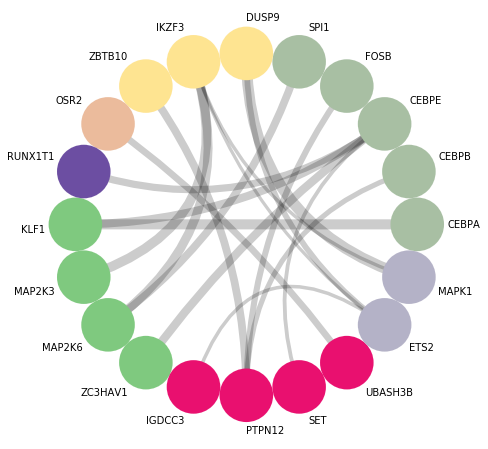

In [13]:
from nxviz import CircosPlot

c = CircosPlot(buf_G,
               node_order='cluster',
               edge_width='emap',
               node_labels='name',
               node_color='color',
               figsize=[8, 8],)
c.draw()
plt.savefig('./figures/orienting_interactions_circos.pdf')